# T-Maze with $\varepsilon$ set to 0 after 100k timesteps

Essentially removing the exploration to check whether it is causing the dips in results. It is noticeable in the plots where the exploration has been completely removed. However, the dips still occur.

Not a prediction problem.

In [2]:
import mariadb
import sys
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os

# JupyterLab renderer support
#jupyter labextension install jupyterlab-plotly@4.14.3

# OPTIONAL: Jupyter widgets extension
#jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.14.3

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
plt.rcParams["figure.figsize"] = (10,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})

#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [4]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run", timestep_col_name="episode"):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            self.conn = mariadb.connect(user='hshah1',
                                        password=os.environ['cedarsqlpswd'],
                                        host='127.0.0.1',
                                        port=3307,
                                        database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [5]:
db = DbAccessor('hshah1_tmaze_e0')
db.get_table('runs', index=False)

,add_features,comment,data_driven_initialization,epsilon,features_acc_thresh,features_min_timesteps,gamma,max_episodes,name,num_layers,num_new_features,run,seed,sparsity,step_size,steps,tmaze_corridor_length,width
0,false,exp_anneal,false,0.05,0.9,100000,0.98,400000,tmaze_e0,10,5,1,2,0,3e-5,10000000,2,10
1,false,exp_anneal,false,0.05,0.9,100000,0.98,400000,tmaze_e0,10,5,2,3,0,3e-5,10000000,2,10
2,false,exp_anneal,false,0.05,0.9,100000,0.98,400000,tmaze_e0,10,5,3,4,0,3e-5,10000000,2,10
3,false,exp_anneal,false,0.05,0.9,100000,0.98,400000,tmaze_e0,10,5,4,5,0,3e-5,10000000,2,10
4,false,exp_anneal,false,0.05,0.9,100000,0.98,400000,tmaze_e0,10,5,5,1,0,3e-5,10000000,2,10


In [6]:
db.get_table('run_states', index=False)

,run,run_state,run_state_comments
0,1,finished,
1,2,finished,
2,3,finished,
3,4,finished,
4,5,finished,


#### While one of the seeds is still learning despite exploration being removed, the thing to note here is the purple run. It has already learned, but it is still dipping.

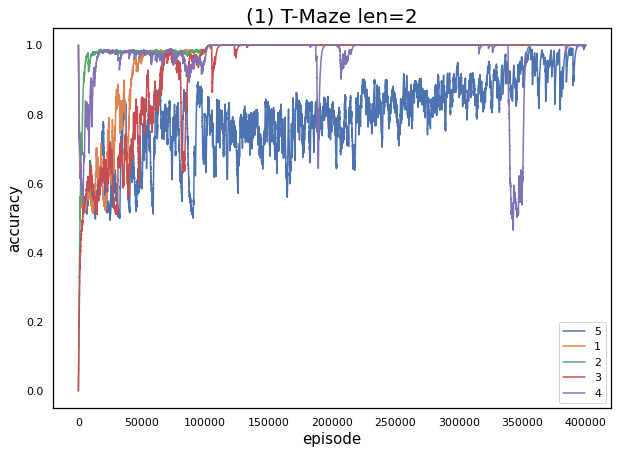

In [8]:
plt.title('(1) T-Maze len=2')
plt.xlabel('episode')
plt.ylabel('accuracy')
for k in [5,1,2,3,4]:
    plt.plot(db.get_table('episodic_metrics', k, 'accuracy'), label=k)
plt.legend()
plt.show()

#### Timesteps taken per episode. Note: no_ops included here

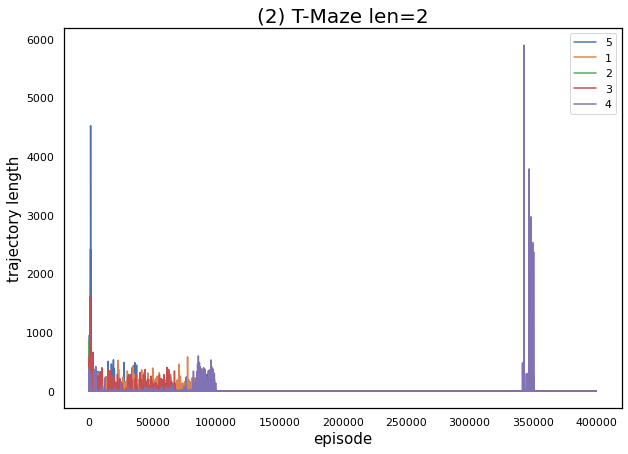

In [11]:
plt.title('(2) T-Maze len=2')
plt.xlabel('episode')
plt.ylabel('trajectory length')
for k in [5,1,2,3,4]:
    plt.plot(pd.read_sql(f'select step from episodic_metrics where run={k}', db.conn)['step'].diff()[1:], label=k)
plt.legend()
plt.show()

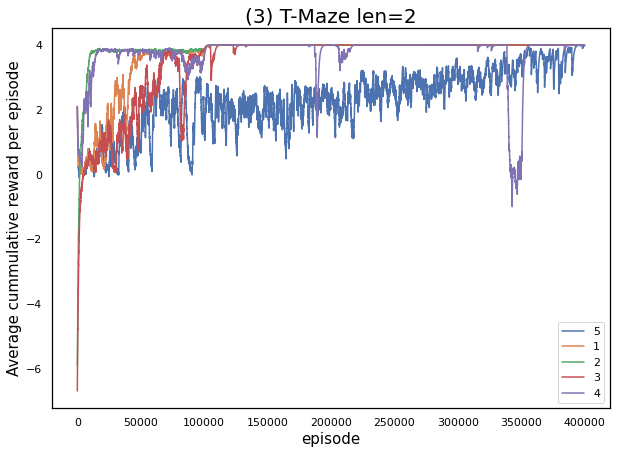

In [10]:
plt.title('(3) T-Maze len=2')
plt.xlabel('episode')
plt.ylabel('Average cummulative reward per episode')
for k in [5,1,2,3,4]:
    plt.plot(db.get_table('episodic_metrics', k, 'avg_reward'), label=k)
plt.legend()
plt.show()